<a href="https://colab.research.google.com/github/microprediction/precise/blob/main/examples_portfolios/parity/proportional_parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install riskparityportfolio
!pip install precise
!pip install git+https://github.com/microprediction/humpday.git

In [11]:
from precise.skaters.covarianceutil.covrandom import rnd_symm_cov
import riskparityportfolio as rp
import numpy as np 
from typing import List 

def normalize(x):
  return np.array(x)/np.sum(x)

def dim_from_partition(partition):
  return max( [max(ndxs) for ndxs in partition])+1

def partition_matrix(partition:List[List[int]]):
    """ 
        Just for adding up the allocations
    """
    n_groups = len(partition)
    n_dim = dim_from_partition(partition)
    shape = (n_groups, n_dim)
    A = np.zeros(shape=shape)
    for group_i, ndxs in enumerate(partition):
       n_group = len(ndxs)
       for asset_j in ndxs:
           A[group_i, asset_j] = 1.0
    return A 

def group_normalized_budget(partition):
    """ b is normalized within groups """
    n_dim = dim_from_partition(partition)
    b = np.zeros(n_dim)
    for ndxs in partition:
       n_group = len(ndxs)
       for ndx in ndxs:
           b[ndx] = 1/n_group 
    return b 

def group_allocation_error(w, A, a):
    """ Penalize deviation from desired group allocation
        w  is n_assets x 1  
        A  is n_groups x n_assets  
        a  is length  n_groups  

    """
    desired_alloc = normalize(a)
    w_col = np.array(w).reshape((-1,1))
    actual_alloc = np.squeeze(normalize(np.matmul(A,w_col)))
    sq_err = np.linalg.norm(actual_alloc-desired_alloc)
    return sq_err, actual_alloc
         
def tilted_budget(u, partition):
    """ 
        Tilt the budgets, but they should still add to unity 
    """
    assert len(u)==len(partition)
    b = group_normalized_budget(partition=partition)
    bu = np.copy(b) 
    assert len(u)==len(partition)
    for i, ndxs in enumerate(partition):
       for ndx in ndxs:
          bu[ndx] = u[i]*b[ndx]
    return bu 
 

def tilt(u, cov, a, partition):
    """
         u  - scales the budgets

    """ 
    b_tilt = tilted_budget(u=u, partition=partition)
    A = partition_matrix(partition)
    w = rp.vanilla.design(cov, b=b_tilt)
    sq_err, allocation = group_allocation_error(w=w,A=A,a=a)
    return sq_err, w, allocation


### Example of a feasible allocation

In [58]:
PARTITION = [list(range(1300)),list(range(1300,2350)),list(range(2350,3500))]*2
n_dim = dim_from_partition(PARTITION)
COV = rnd_symm_cov(rho=0.3, severity=0.1, n_dim=n_dim)
known_feasible_alloc = np.array([0.11439489, 0.15308126, 0.23252385]*2)
desired_alloc        = np.array([0.15439489, 0.11308126, 0.23252385]*2)

def _tilt(u):
    return tilt(u=u, cov=COV, a=desired_alloc, partition=PARTITION)[0]

def _allocation(u):
    A = partition_matrix(partition=PARTITION)
    sq_error, w, allocation = tilt(u=u, cov=COV, a=desired_alloc, partition=PARTITION)
    return allocation 
  

import numpy as np
from scipy.optimize import minimize

def constraint(x):
    return np.sum(x) - 1
n_groups = len(PARTITION)
bounds = [(0, 1) for i in range(n_groups)]
con = {'type': 'eq', 'fun': constraint}
options = {'maxiter': 1000, 'ftol': 1e-9}
x0 = np.array([1/n_groups for _ in range(n_groups)])
result = minimize(_tilt, x0, method='SLSQP', constraints=con, bounds=bounds, options=options)
u = result.x
from pprint import pprint
pprint({'budget factors   ':u,'desired alloc.   ':np.array(desired_alloc),'actual allocation':_allocation(u),'allocation diff. ':_allocation(u)-desired_alloc})


{'actual allocation': array([0.15439517, 0.11308157, 0.23252326, 0.15439517, 0.11308157,
       0.23252326]),
 'allocation diff. ': array([ 2.82449624e-07,  3.09795086e-07, -5.92244710e-07,  2.82449624e-07,
        3.09795086e-07, -5.92244710e-07]),
 'budget factors   ': array([0.07816374, 0.07816374, 0.07816374, 0.28232149, 0.17646815,
       0.30671915]),
 'desired alloc.   ': array([0.15439489, 0.11308126, 0.23252385, 0.15439489, 0.11308126,
       0.23252385])}


# Plotting (3d only)
It looks pretty clean

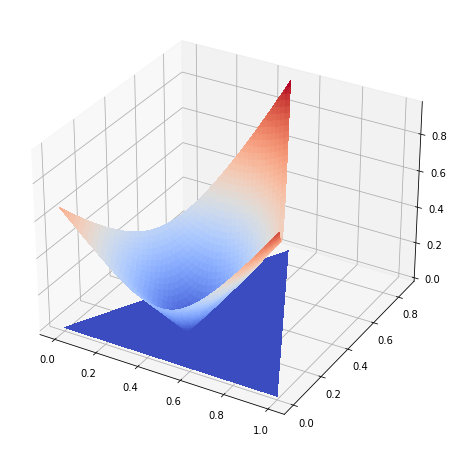

In [31]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10.0, 8.0]
from humpday.visualization.plotting import simplex_surf
simplex_surf(_tilt)